In [1]:
import numpy as np

# import SDR_Test
import matplotlib.pyplot as plt
%matplotlib notebook

# Default Fitting

In [3]:
def receive_fitting(x, ntimes, start, stop, f_sample=28.8e6, tone=1e6, pad=8, shave=300):
    
    t = np.arange(start, stop)/f_sample
    y = 2*np.pi*tone
    lo = np.cos(y*t)-1j*np.sin(y*t)#
    wave = x[shave:-shave]
    mw = wave*(lo[shave:-shave])#

    #mw = z.copy()
    #mw = np.mean(mw, axis =0)
    
    mw_fft = (np.fft.fft(mw))
    mw_fft[pad+1:-pad] = 0
    i = np.argmax(np.abs(mw_fft))
    mw = np.fft.ifft(mw_fft)

    mw /= np.abs(mw)
    
    
    FREQS_z = ((np.fft.fftfreq(mw.size, np.median(np.diff(t)))/1))
        
    #i = np.argmax(np.abs(mw_fft))
    print('i:', i)
    
    
    if i != 0:
        print('broke')
        return 0
        #reset = (np.conjugate(mw_fft[0])/np.abs(mw_fft[0]))#
        
        #d_f = (f_sample/(tone))*FREQS_z[i]
        #return d_f
    else:
        reset = (np.conjugate(mw_fft[i])/np.abs(mw_fft[i]))
        big = ((reset)*(mw))
        slope, intercept = np.polyfit(t[shave:-shave], big.imag, 1)
        d_f = (slope*f_sample)/(y-slope)
        print(f'{d_f=}')
        return d_f

    
    
# f_sample = 10e6 'our gps reference'

def receive_sync(d_f):
    max_freq = 28801126
    min_freq = 28799479
    #max_freq = 28800979
    #min_freq = 28799812
    freq_range = max_freq-min_freq
    bit_amount = 4096
    #bit_amount = 3276
    diff = freq_range/bit_amount
    changing = np.round((d_f/diff))
    changing = changing*diff
    return changing


# Fitting with Noise

In [4]:
def receive_fitting_noise(x, ntimes, nblocks, start, stop, f_sample=28.8e6, tone=1e6, pad=8, shave=300):
    blocks = []
    for i in range(nblocks):
        t = np.arange(start, stop)/f_sample
        y = 2*np.pi*tone
        lo = np.cos(y*t)-1j*np.sin(y*t)#
        blocks.append(lo)
        start += ntimes
        stop += ntimes
    blocks = np.array(blocks)
    lo_fft = np.fft.fft(blocks)
    lo_ave = np.mean(np.abs(lo_fft), axis=0)
    lo_ind = np.argmax(lo_ave)
    lo_ave[:lo_ind-0] = 0
    lo_ave[lo_ind+1:] = 0
    lo_ifft = np.fft.ifft(lo_ave)
#     lo_ifft = np.fft.fft(lo_fft)
    
    
    
    
    wave = x[shave:-shave]
    mw = wave*(lo_ifft[shave:-shave])#
    
    plt.figure()
    plt.plot(mw, label = 'mw')
    plt.legend()
    plt.show()

    #mw = z.copy()
    #mw = np.mean(mw, axis =0)
    
    mw_fft = (np.fft.fft(mw))
    
    plt.figure()
    plt.plot(np.abs((mw_fft)), label = 'mw_fft')
    plt.legend()
    plt.show()
    
    mw_fft[pad+1:-pad] = 0
    i = np.argmax(np.abs(mw_fft))
    mw = np.fft.ifft(mw_fft)

    mw /= np.abs(mw)
    
    FREQS_z = ((np.fft.fftfreq(mw.size, np.median(np.diff(t)))/1))
    
    plt.figure()
    plt.plot(lo_ifft[shave:-shave], label = 'lo')
    plt.plot(wave*20, label = 'x')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(mw, label = 'mw after filter')
    plt.legend()
    plt.show()
    

        
    #i = np.argmax(np.abs(mw_fft))
    print('i:', i)
    
    
    if i != 0:
        print('broke')
        return 0
        #reset = (np.conjugate(mw_fft[0])/np.abs(mw_fft[0]))#
        
        #d_f = (f_sample/(tone))*FREQS_z[i]
        #return d_f
    else:
        reset = (np.conjugate(mw_fft[i])/np.abs(mw_fft[i]))
        big = ((reset)*(mw))
        slope, intercept = np.polyfit(t[shave:-shave], big.imag, 1)
        
        plt.figure()
        plt.plot(big.imag, label = 'big.imag')
        plt.legend()
        plt.show()
        
        d_f = (slope*f_sample)/(y-slope)
        print(f'{d_f=}')
        return d_f

    
    
# f_sample = 10e6 'our gps reference'

def receive_sync_noise(d_f):
    max_freq = 28801126
    min_freq = 28799479
    #max_freq = 28800979
    #min_freq = 28799812
    freq_range = max_freq-min_freq
    bit_amount = 4096
    #bit_amount = 3276
    diff = freq_range/bit_amount
    changing = np.round((d_f/diff))
    changing = changing*diff
    return changing


In [5]:
class SDR:
    def __init__(self, nsamples, sample_freq, sample_rate, nblocks, noise=0):
        self.sample_freq = sample_freq
        self.sample_rate = sample_rate
        self.nblocks = nblocks
        self.nsamples = nsamples
        self.noise = noise
    
    def hello(self):#
        print('hello')#
        
#     def data(self):
#         ntimes = np.linspace(0, 1, 12288)
#         self.sin = np.sin(2*np.pi*self.sample_freq*ntimes)
#         return self.sin
    
    def data(self, start, stop):
        blocks = []
        if self.noise != 0:
            for i in range(self.nblocks):
                ntimes = np.arange(start, stop)/self.sample_rate
                self.sin = np.sin(2*np.pi*self.sample_freq*ntimes) + np.random.normal(loc = 0, scale = self.noise, size = self.nsamples)
                blocks.append(self.sin)
                start += self.nsamples
                stop += self.nsamples
        else:
            
            for i in range(self.nblocks):
                ntimes = np.arange(start, stop)/self.sample_rate
                self.sin = np.sin(2*np.pi*self.sample_freq*ntimes)
                blocks.append(self.sin)
                start += self.nsamples
                stop += self.nsamples
            
        blocks = np.array(blocks)
        return blocks
    
    
    def capture(self):
        blocks = []
        sample = int(np.round(self.sample_freq/self.sample_rate))
        print(sample)
        for i in range(self.nblocks):
            x = self.data()
            blocks.append(x)
        blocks = np.array(blocks)
        return blocks[:,::sample]

# Noise Reduction

<IPython.core.display.Javascript object>


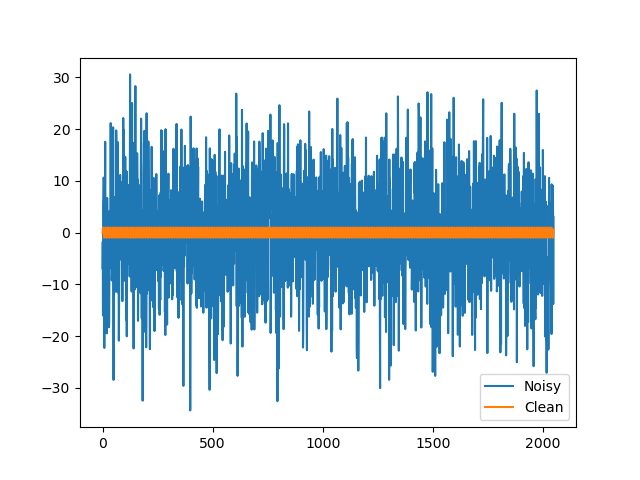

<IPython.core.display.Javascript object>


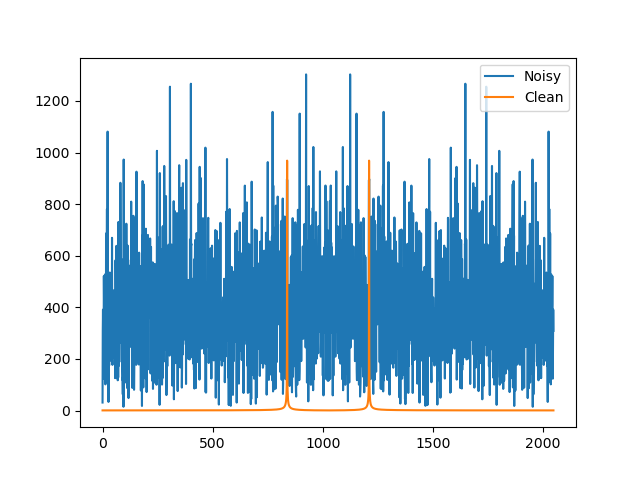

<IPython.core.display.Javascript object>


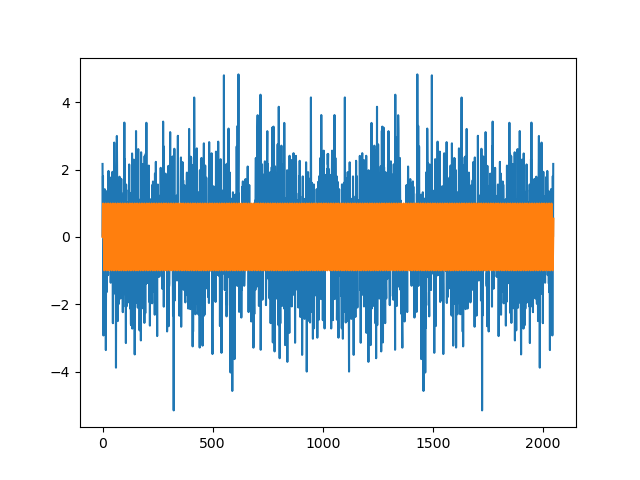

In [218]:
test =  SDR(2048, .2e6, 2.2e6, 10, noise=True)
clean = SDR(2048, .2e6, 2.2e6, 10, noise=False)
clean_data = clean.data(0, 2048)
data = test.data(0, 2048)

# data[0] /= np.mean(data[0], axis=0)

plt.figure()
plt.plot(data[0], label = 'Noisy')
plt.plot(clean_data[0], label = 'Clean')
plt.legend()
plt.show()

fft_data =  (np.fft.fft(data))
fft_clean = (np.fft.fft(clean_data))

plt.figure()
plt.plot(np.abs(np.fft.fftshift(fft_data[0])), label = 'Noisy')
plt.plot(np.abs(np.fft.fftshift(fft_clean[0])), label = 'Clean')
plt.legend()
plt.show()

fft_ave = np.mean(np.abs(fft_data), axis=0)
ifft = np.fft.ifft(fft_ave)

plt.figure()
plt.plot(ifft[1:])
plt.plot(clean_data[0])
plt.show()

186
1256.7998170060125
186
969.2112498248711


<IPython.core.display.Javascript object>


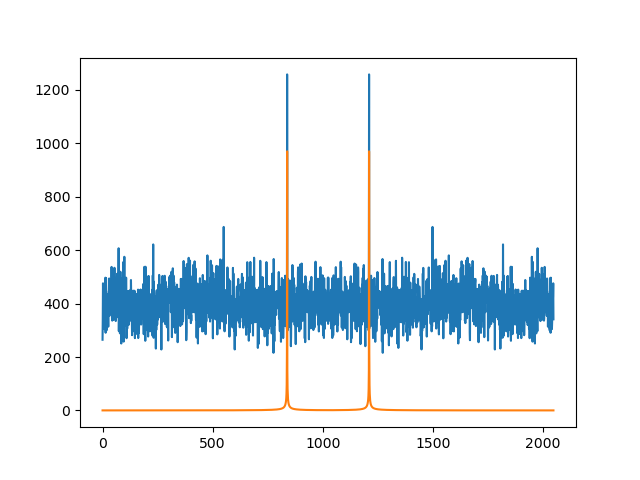

<IPython.core.display.Javascript object>


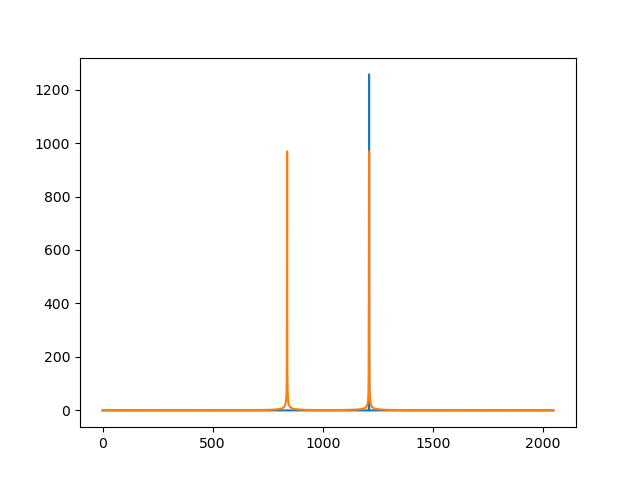

<IPython.core.display.Javascript object>


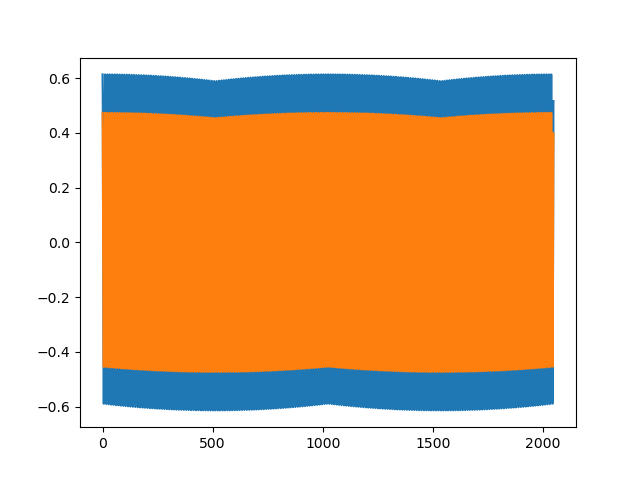

In [227]:
test =  SDR(2048, .2e6, 2.2e6, 10, noise=True)
clean = SDR(2048, .2e6, 2.2e6, 10, noise=False)
clean_data = clean.data(0, 2048)
data = test.data(0, 2048)

fft_data =  (np.fft.fft(data))
fft_clean = (np.fft.fft(clean_data))

fft_data_ave = np.mean(np.abs((fft_data)), axis=0)
ind_max = np.argmax(fft_data_ave)
print(ind_max)
print(np.max(fft_data_ave))

fft_clean_ave = np.mean(np.abs((fft_clean)), axis=0)
ind_max_ = np.argmax(fft_clean_ave)
print(ind_max_)
print(np.max(fft_clean_ave))



plt.figure()
plt.plot(np.abs(np.fft.fftshift(fft_data_ave)))
plt.plot(np.abs(np.fft.fftshift(fft_clean_ave)))
plt.show()

fft_data_ave_filter = np.copy(fft_data_ave)
fft_data_ave_filter[:ind_max-0] = 0
fft_data_ave_filter[ind_max+1:] = 0

fft_clean_ave_filter = np.copy(fft_clean_ave)
fft_clean_ave_filter[:ind_max_-0] = 0
fft_clean_ave_filter[ind_max_+1:] = 0



plt.figure()
plt.plot(np.fft.fftshift(fft_data_ave_filter))
plt.plot(((np.fft.fftshift(fft_clean_ave))))
plt.show()

ifft_ = np.fft.ifft(fft_data_ave_filter)

ifft_clean = np.fft.ifft(fft_clean_ave_filter)

plt.figure()
plt.plot(ifft_)
plt.plot(ifft_clean)
# plt.plot(clean_data[0])
plt.show()

clean_ind=7448
data_ind=744


<IPython.core.display.Javascript object>


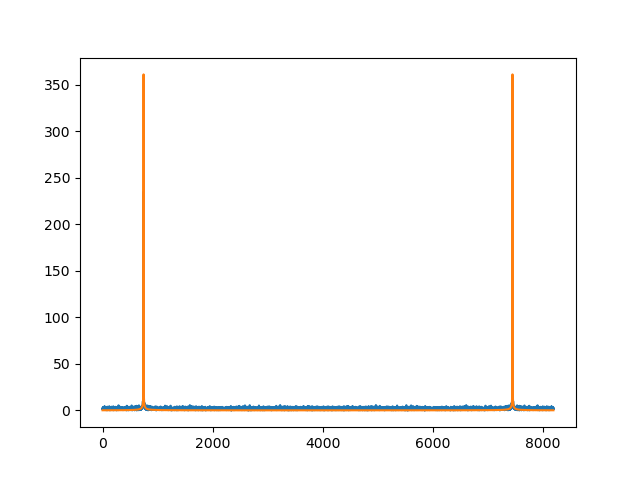

<IPython.core.display.Javascript object>


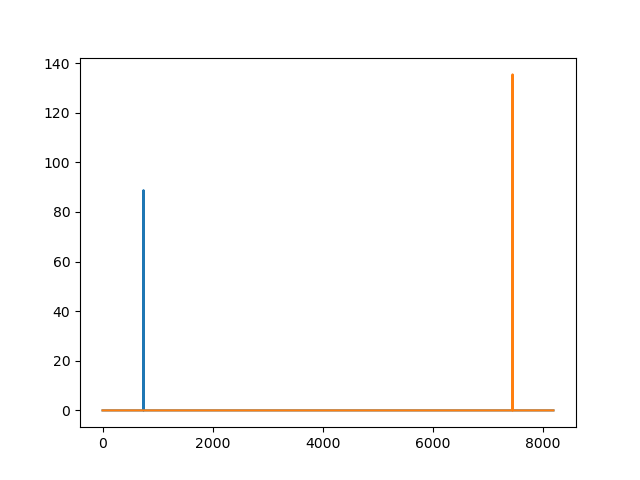

<IPython.core.display.Javascript object>


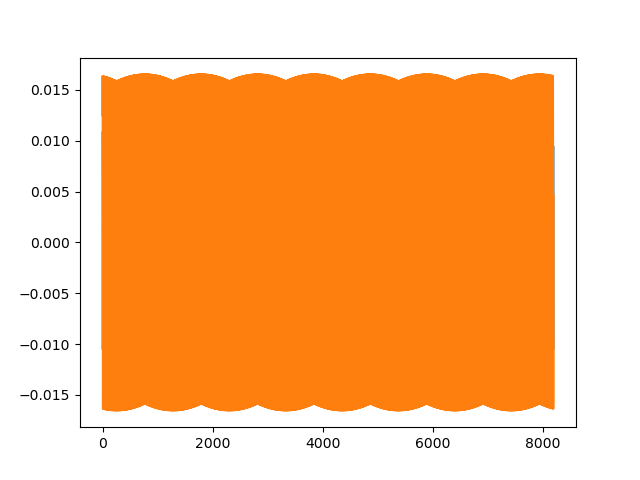

<IPython.core.display.Javascript object>


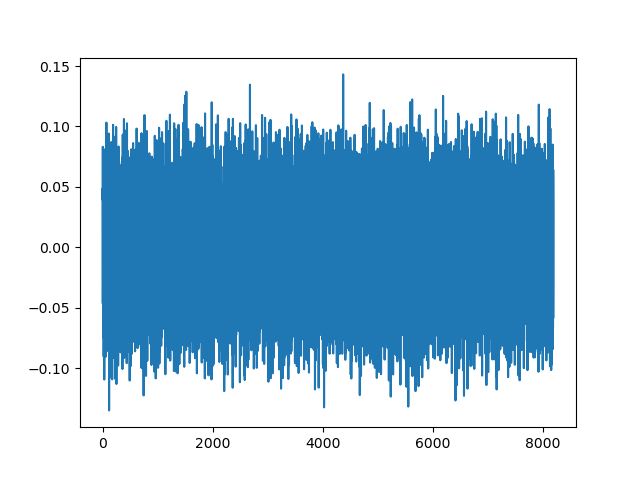

In [68]:
test =  SDR(8192, .2e6, 2.2e6+5, 20, noise=True)
clean = SDR(8192, .2e6, 2.2e6, 10, noise=False)
clean_data = clean.data(0, 8192)
data = test.data(0, 8192)

fft_clean = np.fft.fft(clean_data)
fft_data = np.fft.fft(data)

ave_clean = np.mean((fft_clean), axis=0)
ave_data = np.mean((fft_data), axis=0)

clean_ind = np.argmax(ave_clean)
data_ind = np.argmax(ave_data)

clean_filter = np.copy(fft_clean)

clean_filter = np.mean(clean_filter, axis=0)

clean_filter[:clean_ind-0] = 0
clean_filter[clean_ind+1:] = 0

data_filter = np.copy(fft_data)

data_filter = np.mean(data_filter, axis=0)

data_filter[:data_ind-0] = 0
data_filter[data_ind+1:] = 0


clean_wave = np.fft.ifft(clean_filter)
data_wave = np.fft.ifft(data_filter)

print(f'{clean_ind=}')
print(f'{data_ind=}')


plt.figure()
plt.plot(np.abs(ave_data))
plt.plot(np.abs(ave_clean))
plt.show()

plt.figure()
plt.plot(np.abs(data_filter))
plt.plot(np.abs(clean_filter))
plt.show()

plt.figure()
plt.plot(data_wave)
plt.plot(clean_wave)
plt.show()

plt.figure()
plt.plot(np.fft.ifft(ave_data))
plt.show()

<IPython.core.display.Javascript object>


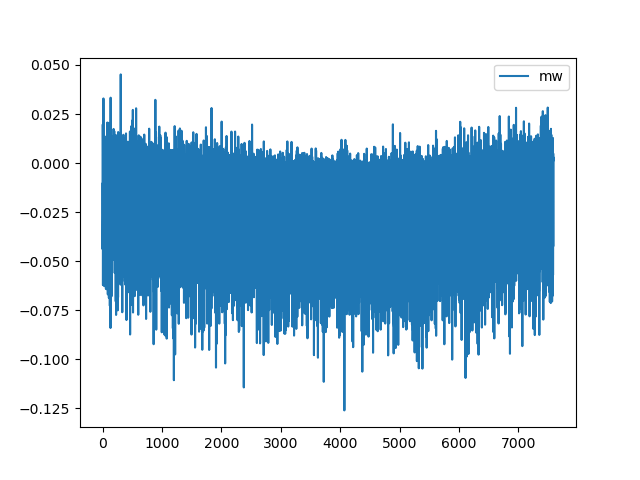

<IPython.core.display.Javascript object>


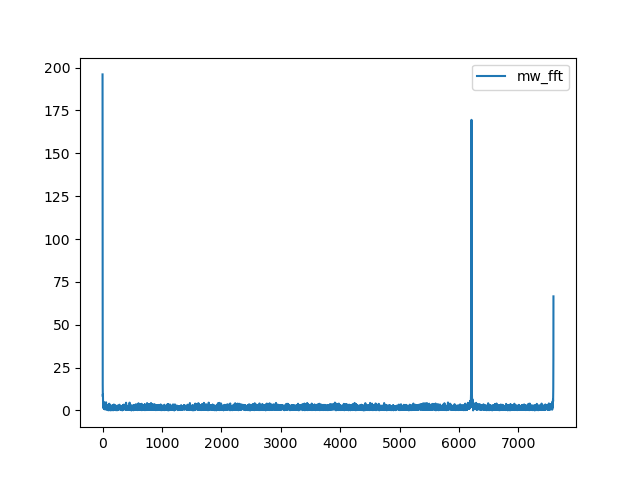

<IPython.core.display.Javascript object>


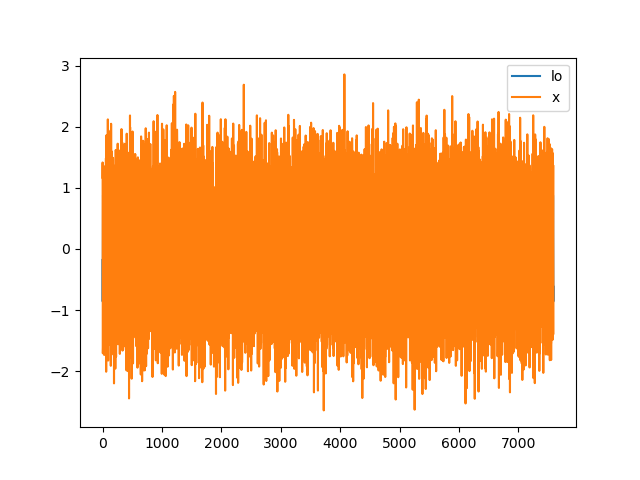

<IPython.core.display.Javascript object>


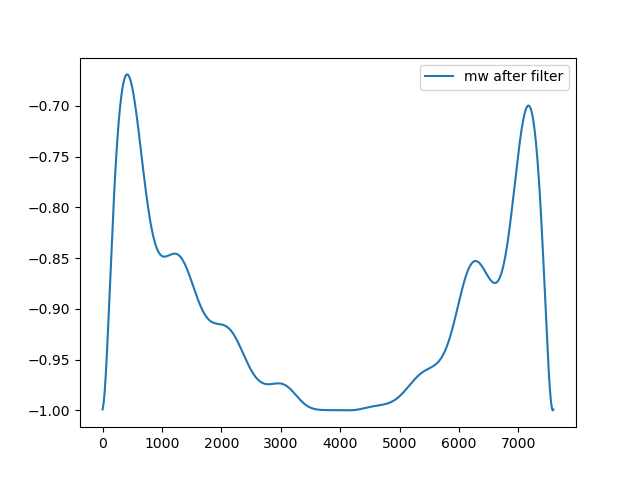

i: 0


<IPython.core.display.Javascript object>


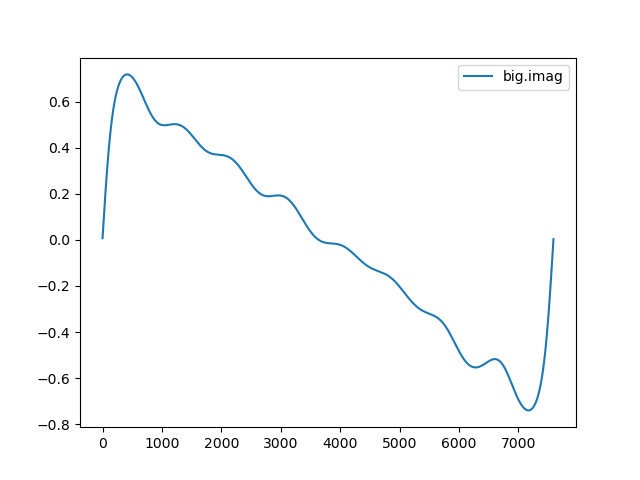

d_f=-704.964067232092
-704.964067232092


<IPython.core.display.Javascript object>


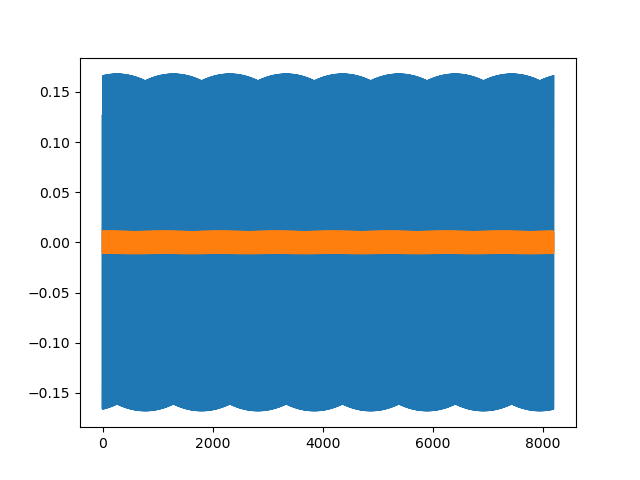

In [69]:
df = receive_fitting_noise(x=np.fft.ifft(ave_data), ntimes=data_wave.shape[0], nblocks=20, 
                      start=0, stop=8192, 
                      f_sample = 2.2e6, tone = .2e6)
print(df)

for i in range(10):
    fft_clean[i][:clean_ind] = 0
    fft_clean[i][clean_ind+1:] = 0
    
for i in range(10):
    fft_data[i][:data_ind] = 0
    fft_data[i][data_ind+1:] = 0

    
data_fixed = np.fft.ifft(fft_data)
clean_fixed = np.fft.ifft(fft_clean)

plt.figure()
plt.plot(data_fixed[0])
plt.plot(data_wave)
# plt.plot(clean_fixed[0])
plt.show()

# df = receive_fitting(x=data_fixed[0], ntimes=data_fixed.shape[0], 
#                       start=0, stop=8192, 
#                       f_sample = 2.2e6, tone = .2e6)
# print(df)

# Default Sync

Everything initialized...
Starting loop...
Capturing SI Data
i: 0
d_f=-150.14936879024202
i: 0
d_f=179.9140349588708
i: 0
d_f=-217.0801888854116
i: 0
d_f=238.0107158492344
i: 0
d_f=-53.37308915949845
i: 0
d_f=-295.7826835760737
i: 0
d_f=-98.94051878834794
i: 0
d_f=-40.20205162794292
i: 0
d_f=134.2464663442484
i: 0
d_f=75.27317722340739
i: 0
d_f=-59.93291514322815
i: 0
d_f=-132.30865743224044
i: 0
d_f=154.0530714314203
i: 0
d_f=-311.01715196662866
i: 0
d_f=247.18921166543961
i: 0
d_f=-123.23142436827703
i: 0
d_f=-377.9750677278783
i: 0
d_f=-37.33802837373044
i: 0
d_f=-47.572813197228854


<IPython.core.display.Javascript object>


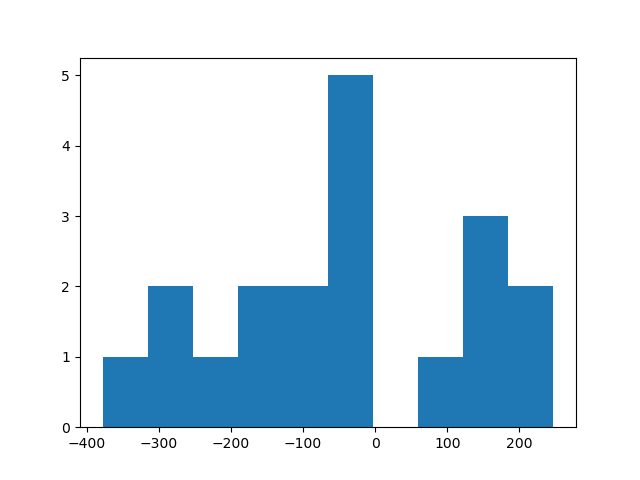

self.std_SI=178.3413612653855
self.SI_average=-48.22196218758461
SI Data Captured...
SI average df: -80.44144350388548
df Difference: -80.44144350388548
Changing: -80.419921875
Appended df Values...
self.sample_rate=2200080.419921875
Actual Sample Rate: 2200020.419921875
Capturing SI Data
i: 0
d_f=237.5315097740762
i: 0
d_f=273.2200492471895
i: 0
d_f=-37.67700298140394
i: 0
d_f=-223.58909425539875
i: 0
d_f=-155.5108093403618
i: 0
d_f=-54.75016737243449
i: 0
d_f=-61.06386826850758
i: 0
d_f=157.34368263671632
i: 0
d_f=-0.270561534286087
i: 0
d_f=72.58607742301955
i: 0
d_f=-713.175747633454
i: 0
d_f=-67.88594122401707
i: 0
d_f=149.06965585314603
i: 0
d_f=86.92099394998849
i: 0
d_f=-338.79398526630297
i: 0
d_f=7.6987661628029285
i: 0
d_f=291.25483408860396
i: 0
d_f=266.7573137332155
i: 0
d_f=313.8730997848703


<IPython.core.display.Javascript object>


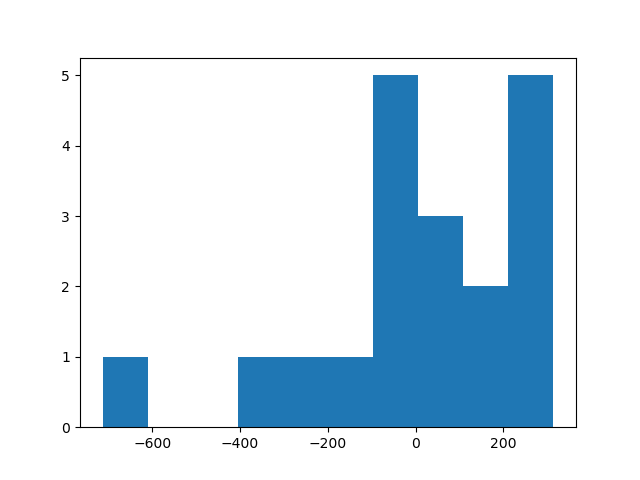

self.std_SI=246.4045064473309
self.SI_average=10.712568672498007
SI Data Captured...
SI average df: 8.492556986410749
df Difference: 8.492556986410749
Changing: 8.444091796875
Appended df Values...
self.sample_rate=2200071.975830078
Actual Sample Rate: 2200011.975830078
Capturing SI Data
i: 0
d_f=5.804938691427207
i: 0
d_f=161.27907342468325
i: 0
d_f=116.85647845431207
i: 0
d_f=-149.4487139135416
i: 0
d_f=0.5352251681482431
i: 0
d_f=292.22703255808096
i: 0
d_f=-364.46888729766306
i: 0
d_f=73.32334216426295
i: 0
d_f=76.68368198595083
i: 0
d_f=142.04865734403486
i: 0
d_f=10.27900883984176
i: 0
d_f=-190.0669888312461
i: 0
d_f=28.436808082343568
i: 0
d_f=157.46620132097547
i: 0
d_f=40.02706346106983
i: 0
d_f=-138.06129902086298
i: 0
d_f=73.75366252673939
i: 0
d_f=-44.65269060446788
i: 0
d_f=131.18689161082068


<IPython.core.display.Javascript object>


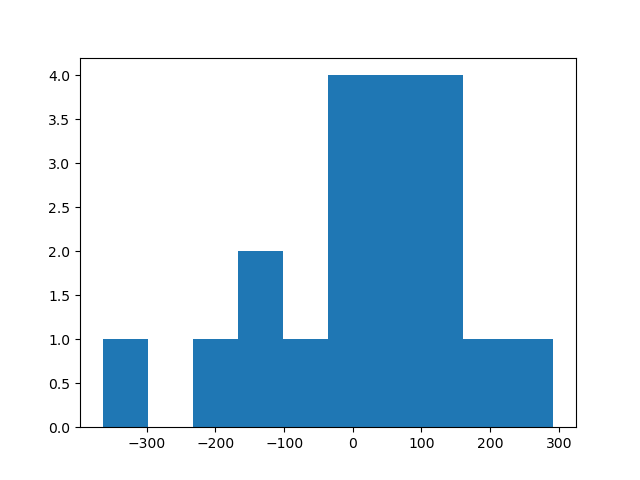

self.std_SI=146.79367730569197
self.SI_average=22.274183471837336
SI Data Captured...
SI average df: 69.502024462153
df Difference: 69.502024462153
Changing: 69.563232421875
Appended df Values...
self.sample_rate=2200002.4125976562
Actual Sample Rate: 2199942.4125976562
Capturing SI Data
i: 0
d_f=-116.87538821022125
i: 0
d_f=-402.5349520483156
i: 0
d_f=-287.262950114062
i: 0
d_f=153.3846336886564
i: 0
d_f=122.97674463776906
i: 0
d_f=91.95598416156106
i: 0
d_f=572.140824623891
i: 0
d_f=-20.862632543890893
i: 0
d_f=-25.163501210655227
i: 0
d_f=-76.86454045380616
i: 0
d_f=217.7116316004326
i: 0
d_f=512.0295577864365
i: 0
d_f=-719.3753986576944
i: 0
d_f=215.63780203706193
i: 0
d_f=-319.48757750457236
i: 0
d_f=293.6164858851963
i: 0
d_f=-374.1358125803705
i: 0
d_f=-334.50554112205583
i: 0
d_f=133.42520056577422


<IPython.core.display.Javascript object>


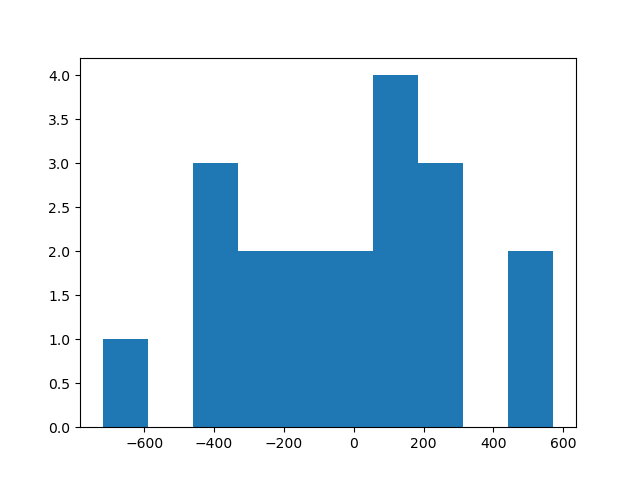

self.std_SI=321.525256619558
self.SI_average=-19.16786470836131
SI Data Captured...
SI average df: 3.4061679583705597
df Difference: 3.4061679583705597
Changing: 3.216796875
Appended df Values...
self.sample_rate=2199999.1958007812
Actual Sample Rate: 2199939.1958007812
Capturing SI Data
i: 0
d_f=363.71917732699603
i: 0
d_f=-364.41177152367175
i: 0
d_f=39.04732871051284
i: 0
d_f=137.3396600532249
i: 0
d_f=91.92727319392027
i: 0
d_f=-98.88718442528051
i: 0
d_f=-117.40438494915058
i: 0
d_f=-186.34381468563228
i: 0
d_f=59.04957668914752
i: 0
d_f=-61.76296561025574
i: 0
d_f=65.83530536198025
i: 0
d_f=474.7587936324925
i: 0
d_f=592.4441536125676
i: 0
d_f=243.97993740503694
i: 0
d_f=-247.36489941890355
i: 0
d_f=104.66988581205557
i: 0
d_f=-146.185762929401
i: 0
d_f=17.74531143959536
i: 0
d_f=181.26195070685628


<IPython.core.display.Javascript object>


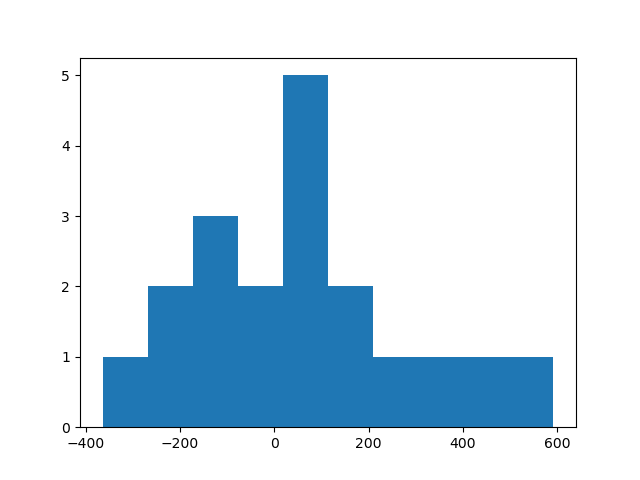

self.std_SI=235.8535486915763
self.SI_average=60.49566160011002
SI Data Captured...
SI average df: 39.739687035249396
df Difference: 39.739687035249396
Changing: 39.807861328125
Appended df Values...
self.sample_rate=2199959.387939453
Actual Sample Rate: 2199899.387939453
done


In [83]:
class match:
    def __init__(self, sample_rate, loops, nsamples, tone):
        self.sample_rate = sample_rate
        self.loops = loops
        self.nsamples = nsamples
        self.tone = tone
        self.sdr_SI = SDR(nsamples=nsamples, sample_freq=self.tone, sample_rate = self.sample_rate+60, nblocks=self.loops, noise=True)
        self.SI_df_value = []
        self.start_SI = 0
        self.stop_SI = self.nsamples
        
        
    def capture_SI(self):
        print('Capturing SI Data')
        SI_df_ave = []
        self.data_SI = self.sdr_SI.data(self.start_SI, self.stop_SI)
        for i in np.arange(1, self.loops):
            SI_df = receive_fitting(self.data_SI[i], self.data_SI[i].shape, self.start_SI, self.stop_SI, f_sample = self.sample_rate, tone = self.tone)
            SI_df_ave.append(SI_df)
            self.start_SI += self.nsamples
            self.stop_SI += self.nsamples
        SI_df_ave = np.array(SI_df_ave)
        
        plt.figure()
        plt.hist(SI_df_ave)
        plt.show()
        
        
        self.SI_average = np.mean((SI_df_ave))
        self.std_SI = np.std((SI_df_ave))
        print(f'{self.std_SI=}')
        print(f'{self.SI_average=}')
        thresh = 1
        filtered_SI = (SI_df_ave)[abs((SI_df_ave)-self.SI_average) <= thresh * self.std_SI]
        self.SI_average = np.mean(filtered_SI)
        print('SI Data Captured...')
        print('SI average df:', self.SI_average)
        
        
    def drift(self):
        diff = self.SI_average
        print('df Difference:', diff)
        changing = receive_sync(diff)
        print('Changing:', changing)
        self.SI_df_value.append(self.SI_average)
        print('Appended df Values...')
        self.sample_rate -= changing
        print(f'{self.sample_rate=}')
        print('Actual Sample Rate:', self.sample_rate-60)
        
        
if __name__ == "__main__":
    sync = match(sample_rate=2.2e6, loops=20, nsamples=8192, tone=.2e6)
    print('Everything initialized...')
    try:
        x=0
        print('Starting loop...')
        while x<5:
            sync.capture_SI()
            sync.drift()
            x += 1
    except(KeyboardInterrupt):
        print('Sync Stopped...')
    finally:
        print('done')

# Sync with Noise

In [9]:
class match:
    def __init__(self, sample_rate, loops, nsamples, tone):
        self.sample_rate = sample_rate
        self.loops = loops
        self.nsamples = nsamples
        self.tone = tone
        self.sdr_SI = SDR(nsamples=nsamples, sample_freq=self.tone, sample_rate = self.sample_rate+60, nblocks=self.loops, noise=False)
        self.SI_df_value = []
        self.start_SI = 0
        self.stop_SI = self.nsamples
        
        
    def capture_SI(self):
        print('Capturing SI Data')
        SI_df_ave = []
        self.data_SI = self.sdr_SI.data(self.start_SI, self.stop_SI)
        self.SI_fft = np.fft.fft(self.data_SI)
        self.SI_ave = np.mean(np.abs(self.SI_fft), axis=0)
        self.SI_ind = np.argmax(self.SI_ave)
        for i in np.arange(1, self.loops):

#             self.SI_ave[:self.SI_ind-0] = 0
#             self.SI_ave[self.SI_ind+1:] = 0
#             self.SI_ifft = np.fft.ifft(self.SI_ave)
            
            self.SI_fft[i][:self.SI_ind] = 0
            self.SI_fft[i][self.SI_ind+1] = 0
            self.SI_ifft = np.fft.ifft(self.SI_fft[i])
            SI_df = receive_fitting(x=self.SI_ifft, ntimes=self.SI_ifft.shape[0], start=self.start_SI, stop=self.stop_SI, f_sample = self.sample_rate, tone = self.tone)
            SI_df_ave.append(SI_df)
            self.start_SI += self.nsamples
            self.stop_SI += self.nsamples
        SI_df_ave = np.array(SI_df_ave)
        self.SI_average = np.mean((SI_df_ave))
        self.std_SI = np.std((SI_df_ave))
        thresh = 1
        filtered_SI = (SI_df_ave)[abs((SI_df_ave)-self.SI_average) <= thresh * self.std_SI]
        self.SI_average = np.mean(filtered_SI)
        print('SI Data Captured...')
        print('SI average df:', self.SI_average)
        
        
    def drift(self):
        diff = self.SI_average
        print('df Difference:', diff)
        changing = receive_sync(diff)
        print('Changing:', changing)
        self.SI_df_value.append(self.SI_average)
        print('Appended df Values...')
        self.sample_rate -= changing
        print(f'{self.sample_rate=}')
        print('Actual Sample Rate:', self.sample_rate-60)
        
        
if __name__ == "__main__":
    sync = match(sample_rate=2.2e6, loops=20, nsamples=8192, tone=.2e6)
    print('Everything initialized...')
    try:
        x=0
        print('Starting loop...')
        while x<10:
            sync.capture_SI()
            sync.drift()
            x += 1
    except(KeyboardInterrupt):
        print('Sync Stopped...')
    finally:
        print('done')

Everything initialized...
Starting loop...
Capturing SI Data
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
i: 7584
broke
SI Data Captured...
SI average df: 0.0
df Difference: 0.0
Changing: 0.0
Appended df Values...
self.sample_rate=2200000.0
Actual Sample Rate: 2199940.0
Capturing SI Data
i: 0
d_f=642.7240490173677
i: 0
d_f=642.6292734768945
i: 0
d_f=642.6444873859616
i: 0
d_f=642.7128728045202
i: 0
d_f=642.5816253534416
i: 0
d_f=642.7397250906724
i: 0
d_f=642.6000459995842
i: 0
d_f=642.6801177774125
i: 0
d_f=642.6811237563536
i: 0
d_f=642.599346970875
i: 0
d_f=642.7399561336646
i: 0
d_f=642.5819446644408
i: 0
d_f=642.7120711722665
i: 0
d_f=642.6455043223049
i: 0
d_f=642.6283187503049
i: 0
d_f=642.724695321862
i: 0
d_f=642.5781513159978
i: 0
d_f=642.7341168953789
i: 0
d_f=642.6127509

(10, 8192)
(8192,)
745 7447


<IPython.core.display.Javascript object>


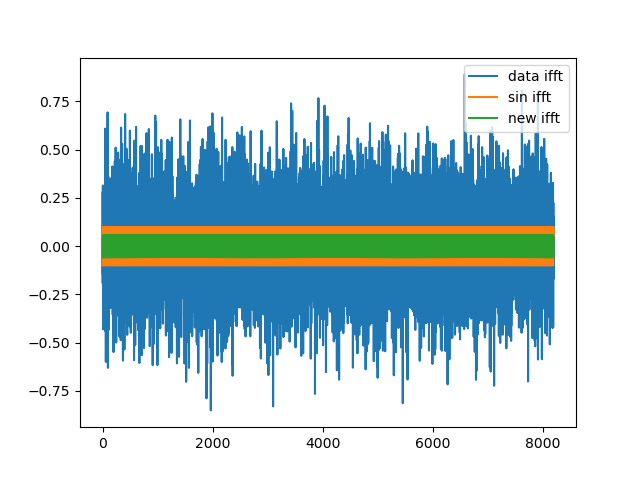

In [10]:
sdr =  SDR(8192, .2e6, 2.2e6+5, 20, noise = 1)
data = sdr.data(0,8192)

ntimes = np.arange(0, 81920)/2.2e6+5
sin = np.sin(2*np.pi*.2e6*ntimes)
sin.shape = (10, -1)
print(sin.shape)

fft_sin = np.fft.fft(sin)
fft_data = np.fft.fft(data)

avg_sin = np.mean(fft_sin, axis=0)
avg_data = np.mean(fft_data, axis=0)

ifft_sin = np.fft.ifft(avg_sin)
ifft_data = np.fft.ifft(avg_data)

first_peak = np.argmax(np.abs(avg_data[:4096]))
second_peak = np.argmax(np.abs(avg_data[4096:-1])) + 4096
print(avg_data.shape)
print(first_peak, second_peak)
new_data = np.copy(avg_data)
new_data[:first_peak] = 0
new_data[first_peak+1:second_peak] = 0
new_data[second_peak+1:] = 0

new_ifft = np.fft.ifft(new_data)



plt.figure()

# plt.plot(data[0], label = 'data')
# plt.plot(sin[0], label = 'sin')

# plt.plot(np.fft.fftshift(np.abs(fft_data[0])), label = 'data fft')
# plt.plot(np.fft.fftshift(np.abs(fft_sin[0])), label = 'sin fft')

# plt.plot(np.abs(avg_data), label = 'average data fft')
# plt.plot((np.abs(new_data)), label = 'new data fft')
# plt.plot(np.fft.fftshift(np.abs(avg_sin)), label = 'average sin fft')

plt.plot(ifft_data, label = 'data ifft')
plt.plot(ifft_sin, label = 'sin ifft')
plt.plot(new_ifft, label = 'new ifft')
plt.legend()
plt.show()